# Homework 2: mask detection for the next pandemic
You heard rumors from biology department of EPFL about a new version of a corona virus spreading out next year, already called COVID-25. The virus is so dangerous that you are asked to develop a mask detection system to be deployed in all public places. The system should be able to detect if a person is wearing a mask or not. You are given a dataset of images of people with and without masks. Your task is to develop a machine learning model that can detect if a person is wearing a mask or not.

**IMPORTANT NOTE:** The evaluation of this homework will be done on an hidden dataset. It is important that your notebook runs without errors, otherwise we will not be able to evaluate some questions, resulting in a grade 0 for that part. Make sure to double check your code before submitting the notebook. We provide a simple `evaluate` function that you can use to make sure that all the necessary functions are implemented correctly; the function will warn you if it detects that a good prediction cannot be made. `evaluate` takes just one argument: the `scikit-learn` model that you have trained. It expects the model to have a `predict` method that works on a numpy array.

In [1]:
from evaluation import evaluate
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample

## Data loading and preprocessing
The dataset consists in $n$ images of dimension 128x128 pixels. Each pixel is represented by 3 values (RGB). The dataset is divided in two classes: 0 for people with the mask and 1 for people without the mask. 

In [2]:
import numpy as np
import sklearn

def load_file(file):
    with np.load('data/'+file+'.npz') as data:
        X = data['X']
        y = data['y']
    return X, y

X, y = load_file('train')
print(X.shape, y.shape)

(188, 3, 128, 128) (188,)


**Question 1.** Plot few images, and check the distribution of the labels.

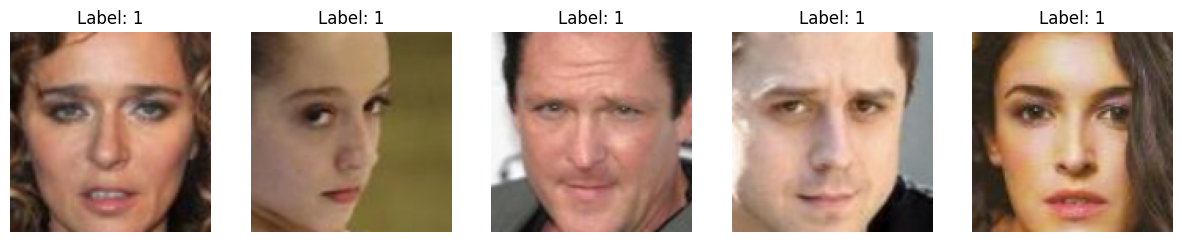

Number of people with a mask: 102 (54.26%)
Number of people without a mask: 86 (45.74%)


In [3]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X[i].transpose(1, 2, 0))
    ax.set_title(f'Label: {y[i]}')
    ax.axis('off')
plt.show()

count_0 = np.sum(y == 0)
count_1 = np.sum(y == 1)
print(f'Number of people with a mask: {count_0} ({count_0 * 100 / len(y):.2f}%)')
print(f'Number of people without a mask: {count_1} ({count_1 * 100 / len(y):.2f}%)')

**Question 2.** Reshape each image in the dataset to a flat vector. Split the dataset into training and test sets.

In [4]:
from sklearn.utils import check_random_state

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Logistic regression

**Question 3.** Train a logistic regression model on the training data, comparing the accuracies of $\ell_1$ and $\ell_2$ penalties. What is the train and test accuracy of the model?

In [5]:
for penalty in ['l1', 'l2']:
    logreg = LogisticRegression(penalty=penalty, solver='liblinear')
    logreg.fit(X_train, y_train)
    print(f"{penalty} penalty - Train Accuracy:", logreg.score(X_train, y_train))
    print(f"{penalty} penalty - Test Accuracy:", logreg.score(X_test, y_test))
    evaluate(logreg)

l1 penalty - Train Accuracy: 1.0
l1 penalty - Test Accuracy: 0.8771929824561403
All good, you are ready for HomeWork submission! The accuracy on 'train' is:  0.9627659574468085
l2 penalty - Train Accuracy: 1.0
l2 penalty - Test Accuracy: 0.8596491228070176
All good, you are ready for HomeWork submission! The accuracy on 'train' is:  0.9574468085106383


**Question 4.** Make a more extensive search of possible Logistic Regressors. Crossvalidate the following parameters:
- penalty: `['l1', 'l2']`
- $C$: range from $10^{-3}$ to $10^3$.


In [5]:
param_grid_lr = [{'logisticregression__C': 1 / np.logspace(-3, 3, 7), 'logisticregression__penalty': ['l1', 'l2'], 'logisticregression__solver': ['liblinear']}]
cv_lr = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
pipeLR = make_pipeline(StandardScaler(), LogisticRegression())
lr = GridSearchCV(pipeLR, param_grid_lr, scoring='accuracy', cv=cv_lr, return_train_score=True, n_jobs = None)

In [7]:
lr.fit(X_train, y_train)
print(f"Best parameters: {lr.best_params_}")
print()
print(f"Train Accuracy: {lr.best_score_}")
print(f"Test Accuracy: {lr.score(X_test, y_test)}")
evaluate(lr)

Best parameters: {'logisticregression__C': np.float64(100.0), 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}

Train Accuracy: 0.925
Test Accuracy: 0.8596491228070176
All good, you are ready for HomeWork submission! The accuracy on 'train' is:  0.9574468085106383


## SVM
**Question 4.** Train a linear SVM model on the training data and crossvalidate the parameter $C$.

In [6]:
param_grid_svm = [{'svc__C': 1 / np.logspace(-3, 3, 7)}]
cv_svm = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
pipeSVM = make_pipeline(StandardScaler(), SVC(kernel='linear'))
svm = GridSearchCV(pipeSVM, param_grid_svm, scoring='accuracy', cv=cv_svm, return_train_score=True, n_jobs = None)

In [9]:
svm.fit(X_train, y_train)

print(f"Best parameters: {svm.best_params_}")
print()
print(f"Train Accuracy: {svm.best_score_}")
print(f"Test Accuracy: {svm.score(X_test, y_test)}")
evaluate(svm)

Best parameters: {'svc__C': np.float64(1000.0)}

Train Accuracy: 0.875
Test Accuracy: 0.8771929824561403
All good, you are ready for HomeWork submission! The accuracy on 'train' is:  0.9627659574468085


## Random Forest

**Question 5.** Train a Random Forest model on the training data and crossvalidate the parameters:
- `n_estimators`
- `max_depth`
- `criteria`



In [7]:
param_grid_rf = [{'randomforestclassifier__n_estimators': [50, 100, 200], 'randomforestclassifier__max_depth': [10, 20, 30], 'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss']}]
cv_rf = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
pipeRF = make_pipeline(StandardScaler(), RandomForestClassifier())
rf = GridSearchCV(pipeRF, param_grid_rf, scoring='accuracy', cv=cv_rf, return_train_score=True, n_jobs = None)

In [11]:
rf.fit(X_train, y_train)

print(f"Best parameters: {rf.best_params_}")
print()
print(f"Train Accuracy: {rf.best_score_}")
print(f"Test Accuracy: {rf.score(X_test, y_test)}")
evaluate(rf)

/home/giorgillo/fundamentals-inference-learning/venv/lib/python3.9/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__n_estimators': 200}

Train Accuracy: 0.885
Test Accuracy: 0.8947368421052632
All good, you are ready for HomeWork submission! The accuracy on 'train' is:  0.9680851063829787


## Extra data
Digging in his archive, EPFL Health autorities found a another dataset of images with the same format. This dataset is called `extratrain`. Use this dataset to improve the performance of your models.

In [8]:
X_extra, y_extra = load_file('extra')
X_extra = X_extra.reshape(X_extra.shape[0], -1)

**Question 6.** Is this new dataset good? What problem does it have compared to the original dataset, if any?

In [8]:
count_0 = np.sum(y_extra == 0)
count_1 = np.sum(y_extra == 1)
print(f'Number of people with a mask: {count_0} ({count_0 * 100 / len(y_extra):.2f}%)')
print(f'Number of people without a mask: {count_1} ({count_1 * 100 / len(y_extra):.2f}%)')

#every person in the extra dataset has a mask

Number of people with a mask: 4629 (100.00%)
Number of people without a mask: 0 (0.00%)


**Question 7.** Evaluate the performance of the cross-validated models you found in the previous questions on the new dataset. Is the performance better or worse? Why?

In [14]:
print(f"Logistic Regression Score: {lr.score(X_extra, y_extra):.2f}")
print(f"SVM Score: {svm.score(X_extra, y_extra):.2f}")
print(f"Random Forest Score: {rf.score(X_extra, y_extra):.2f}")

Logistic Regression Score: 0.85
SVM Score: 0.86
Random Forest Score: 0.93


**Question 8.** Train the most promising model using the new dataset, and crossvalidate. Is the performance better or worse? Why?

In [9]:
X_extra_train, X_extra_test, y_extra_train, y_extra_test = train_test_split(X_extra, y_extra, test_size=0.3, random_state=42)

In [10]:
param_grid_bm = [{'randomforestclassifier__n_estimators': [50, 100, 200], 'randomforestclassifier__max_depth': [10, 20, 30], 'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss']}]
cv_bm = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
pipeBM = make_pipeline(StandardScaler(), RandomForestClassifier())
bm = GridSearchCV(pipeBM, param_grid_bm, scoring='accuracy', cv=cv_bm, return_train_score=True, n_jobs = None)
bm.fit(X_extra_train, y_extra_train)
print(f"Best parameters: {bm.best_params_}")
print()
print(f"Train Accuracy: {bm.best_score_}")
print(f"Test Accuracy: {bm.score(X_extra_test, y_extra_test)}")
evaluate(bm)

KeyboardInterrupt: 

**Question 9:** Join the `train` and `extra` datasets and repeat the previous point. What is the best model and its accuracy on the combined dataset?

In [11]:
X_combined = np.concatenate((X, X_extra), axis=0)
y_combined = np.concatenate((y, y_extra), axis=0)

random_state = check_random_state(0)
permutation = random_state.permutation(X_combined.shape[0])
X_combined = X_combined[permutation]
y_combined = y_combined[permutation]

X_combined_train, X_combined_test, y_combined_train, y_combined_test = train_test_split(X_combined, y_combined, train_size=0.5, test_size=0.2, random_state=42)

In [11]:
param_grid_rf_c = [{'randomforestclassifier__n_estimators': [50, 100, 200], 'randomforestclassifier__max_depth': [10, 20, 30], 'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss']}]
cv_rf_c = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
pipeRF_c = make_pipeline(StandardScaler(), RandomForestClassifier())
rf_c = GridSearchCV(pipeRF_c, param_grid_rf_c, scoring='accuracy', cv=cv_rf_c, return_train_score=True, n_jobs = None)
rf_c.fit(X_combined_train, y_combined_train)

print(f"Train Accuracy: {rf_c.best_score_}")
print(f"Test Accuracy: {rf_c.score(X_combined_test, y_combined_test)}")
evaluate(rf_c)

Train Accuracy: 0.9875518672199171
Test Accuracy: 0.9823651452282157
All good, you are ready for HomeWork submission! The accuracy on 'train' is:  0.8085106382978723


**Question 10:** Resample the joined dataset to solve the joined dataset "problem". Train a Random Forest with crossvalidation and discuss the results.

In [12]:
X_resampled, y_resampled = resample(X_combined, y_combined, replace=True, n_samples=len(X_combined), random_state=42)
X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test = train_test_split(X_resampled, y_resampled, train_size=0.5, test_size=0.3, random_state=42)

param_grid_rf_r = [{'randomforestclassifier__n_estimators': [50, 100, 200], 'randomforestclassifier__max_depth': [10, 20, 30], 'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss']}]
cv_rf_r = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
pipeRF_r = make_pipeline(StandardScaler(), RandomForestClassifier())
rf_r = GridSearchCV(pipeRF_r, param_grid_rf_r, scoring='accuracy', cv=cv_rf_r, return_train_score=True, n_jobs = None)

rf_r.fit(X_resampled_train, y_resampled_train)

print(f"Train Accuracy: {rf_r.best_score_}")
print(f"Test Accuracy: {rf_r.score(X_resampled_test, y_resampled_test)}")


Train Accuracy: 0.9892116182572614
Test Accuracy: 0.9951590594744122


NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [13]:
evaluate(rf_r)

All good, you are ready for HomeWork submission! The accuracy on 'train' is:  0.8191489361702128


**Question 11:** Repeat the previous question, but this time use `LogisticRegression` as the model. 

In [14]:
param_grid_lr_r = [{'logisticregression__C': 1 / np.logspace(-3, 3, 7), 'logisticregression__penalty': ['l1', 'l2'], 'logisticregression__solver': ['liblinear']}]
cv_lr_r = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
pipeLR_r = make_pipeline(StandardScaler(), LogisticRegression())
lr_r = GridSearchCV(pipeLR_r, param_grid_lr_r, scoring='accuracy', cv=cv_lr_r, return_train_score=True, n_jobs = None)
lr_r.fit(X_resampled_train, y_resampled_train)

print(f"Train Accuracy: {lr_r.best_score_}")
print(f"Test Accuracy: {lr_r.score(X_resampled_test, y_resampled_test)}")
evaluate(lr_r)

Train Accuracy: 0.9925311203319502
Test Accuracy: 0.9930843706777317
All good, you are ready for HomeWork submission! The accuracy on 'train' is:  0.8670212765957447


**Question 12:** Train the best model you can given the data available. Describe your technique and justify your choices.

In [ ]:
param_grid_lr_o = {'penalty': ['l1', 'l2'], 'C': np.logspace(-4, 4, 9), 'class_weight': [None, 'balanced']}
cv_lr_o = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
pipeLR_o = make_pipeline(StandardScaler(), LogisticRegression())
lr_o = GridSearchCV(pipeLR_o, param_grid_lr_o, scoring='accuracy', cv=cv_lr_o, return_train_score=True, n_jobs = None)
lr_o.fit(X_train, y_train)

print(f"Train Accuracy: {lr_o.best_score_}")
print(f"Test Accuracy: {lr_o.score(X_resampled_test, y_resampled_test)}")
evaluate(lr_o)

**Question Bonus:** You have been told that is much more important to detect people without masks than people with masks. How would you change your model to take this into account?

Most models in Scikit-Learn, such as LogisticRegression, SVM, and RandomForestClassifier, support the class_weight parameter. In case of an unblanaced dataset, we can manually specify custom weights to emphasize the "without mask" class. This change increases the penalty for misclassifying the "without mask" class, encouraging the model to focus on correctly classifying it.